In [1]:
BATCH_SIZE = 64
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

nbtrain_img  = 'data/mnist_train_imgs.npy'
nbtrain_lab  = 'data/mnist_train_labels.npy'
nbvalid_img = 'data/mnist_test_imgs.npy'
nbvalid_lab = 'data/mnist_test_labels.npy'

Steps per epoch:  937


In [146]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
from sklearn import metrics
from keras.regularizers import l2
from keras.utils.layer_utils import count_params
import numpy as np
from sklearn import metrics
import time
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [3]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [124]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(label):
    label = tf.one_hot(label, 10)
    return label
  
def read_image_normalize(image):
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image

def read_image_standardize(image):
    image = tf.reshape(image, [28,28,1])
    image = tf.image.per_image_standardization(tf.cast(image, tf.float32))
    image = tf.reshape(image, [28*28])
    return image

def load_dataset(image_data, label_data, standardize):
    imagedataset = tf.data.Dataset.from_tensor_slices(image_data)
    if standardize:
      imagedataset = imagedataset.map(read_image_standardize, num_parallel_calls=16)
    else:
      imagedataset = imagedataset.map(read_image_normalize, num_parallel_calls=16)
    labelsdataset = tf.data.Dataset.from_tensor_slices(label_data)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size, standardize=False):
    dataset = load_dataset(image_file, label_file, standardize)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset

def get_validation_dataset(image_file, label_file, standardize=False):
    dataset = load_dataset(image_file, label_file, standardize)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

plot_training = PlotTraining(sample_rate=10, zoom=1)

In [6]:
train_img = np.load(nbtrain_img)
train_lab = np.load(nbtrain_lab)
valid_img = np.load(nbvalid_img)
valid_lab = np.load(nbvalid_lab)

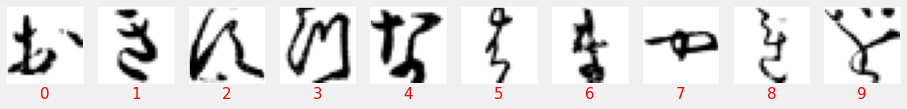

In [90]:
i = 10
k = 0
s = set()
while k <= 9:
  if train_lab[i] == k :
    s.add(train_lab[i])
    plt.subplot(1,10, k + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_img[i])
    plt.xlabel(train_lab[i], fontsize=15, color='red')
    k += 1
  i += 1
plt.show()

In [20]:
training_dataset = get_training_dataset(train_img, train_lab, BATCH_SIZE, False)
validation_dataset = get_validation_dataset(valid_img, valid_lab, False)

(28, 28, 1)


In [8]:
#taking a batch of 64 samples
if tf.executing_eagerly():
    for i, _ in training_dataset:
      vi = i.numpy()
      break
else:
  v_images, v_labels = training_dataset.make_one_shot_iterator().get_next()
  with tf.Session() as ses:
    vi = ses.run([v_images])

In [95]:
#normalized values
vi[0][30:50]

array([0.0078125 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.53515625, 0.99609375,
       0.99609375, 0.99609375, 0.99609375, 0.578125  , 0.0234375 ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [10]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
#plot_learning_rate(lr_decay, EPOCHS)

DATA AUGMENTATION

In [11]:
#change rotation and zoom to adapt different writting styles
data_augmentation = tf.keras.Sequential([    
  tf.keras.layers.Reshape(input_shape=(28 , 28,), target_shape=(28, 28, 1)),
  tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.01),
])

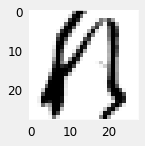

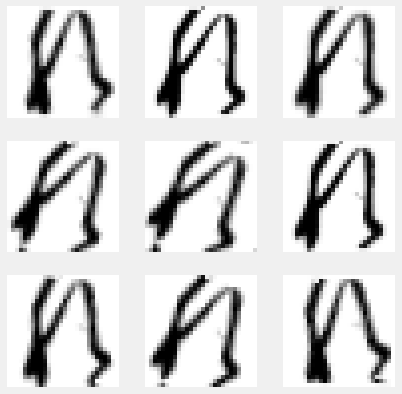

In [75]:
plt.figure(figsize=(2, 2))
plt.imshow(train_img[0])
image = tf.expand_dims(train_img[0], 0)
plt.show()
plt.figure(figsize=(7, 7))
for i in range(9):
  augmented_image = data_augmentation(image)
  plt.subplot(3, 3, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(np.squeeze(augmented_image[0]))
  plt.axis("off")
plt.show()

**MODEL & TUNING**

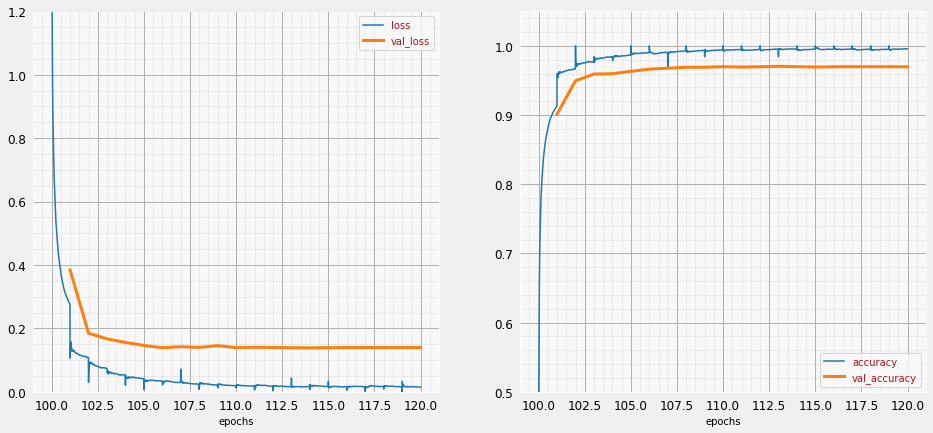

937/937 [==============================] - 5s 5ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.1395 - val_accuracy: 0.9697
Total training time : 91.582 sec


In [91]:
def trainmodel(td, vd, kernel, filter, ep, data_augmetation, padding='same'):
  augmentation = tf.keras.Sequential([
      tf.keras.layers.Reshape(input_shape=(28 * 28,), target_shape=(28, 28, 1))
    ])
  
  if data_augmentation:
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)))
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.01))  

  model = tf.keras.Sequential(
    [
        augmentation,
        
        tf.keras.layers.Conv2D(kernel_size=kernel[0], filters=filter[0], use_bias=False, padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Conv2D(kernel_size=kernel[1], filters=filter[1], use_bias=False, padding= padding, strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Conv2D(kernel_size=kernel[2], filters=filter[2], use_bias=False, padding= padding, strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  starttime = time.time()
  history = model.fit(td, steps_per_epoch=steps_per_epoch, epochs= ep,
                    validation_data=vd, validation_steps=1, 
                    callbacks=[plot_training, lr_decay_callback])
  #callbacks=[plot_training, lr_decay_callback])

  print("Total training time : {0:.5g} sec".format(time.time() - starttime))
  return (history, model)
(history, model) = trainmodel(training_dataset, validation_dataset, [3,6,6], [12, 24, 32], 20, False)

In [92]:
pred = model.predict(validation_dataset, steps= 1)
pred = np.argmax(pred, axis=1)

In [93]:
#row : prediction , col : true class
print(pd.DataFrame(metrics.confusion_matrix(pred,valid_lab)))

     0    1    2    3    4    5    6    7    8    9
0  962    1    7    0    9    0    0    2    0    3
1    2  957    0    0    4    6    1    1    7    2
2    0    5  928    5    2   20    6    2    0    1
3    1    0   27  987    2    6    1    0    2    0
4   26    6    8    0  963    2    0    2    2    1
5    0    0    7    3    1  953    1    0    0    0
6    0   20   11    4    6    8  989    1    0    1
7    3    1    4    0    5    0    1  988    2    1
8    6    6    5    1    7    3    1    3  986    7
9    0    4    3    0    1    2    0    1    1  984


In [94]:
print(metrics.classification_report(pred, valid_lab, digits=3))

              precision    recall  f1-score   support

           0      0.962     0.978     0.970       984
           1      0.957     0.977     0.967       980
           2      0.928     0.958     0.943       969
           3      0.987     0.962     0.974      1026
           4      0.963     0.953     0.958      1010
           5      0.953     0.988     0.970       965
           6      0.989     0.951     0.970      1040
           7      0.988     0.983     0.986      1005
           8      0.986     0.962     0.974      1025
           9      0.984     0.988     0.986       996

    accuracy                          0.970     10000
   macro avg      0.970     0.970     0.970     10000
weighted avg      0.970     0.970     0.970     10000



Le modèle donne déjà de bons résultats avec un loss constant pour le validation set, mais l'accuracy aussi.

In [96]:
#standardized
training_dataset = get_training_dataset(train_img, train_lab, BATCH_SIZE, True)
validation_dataset = get_validation_dataset(valid_img, valid_lab, True)

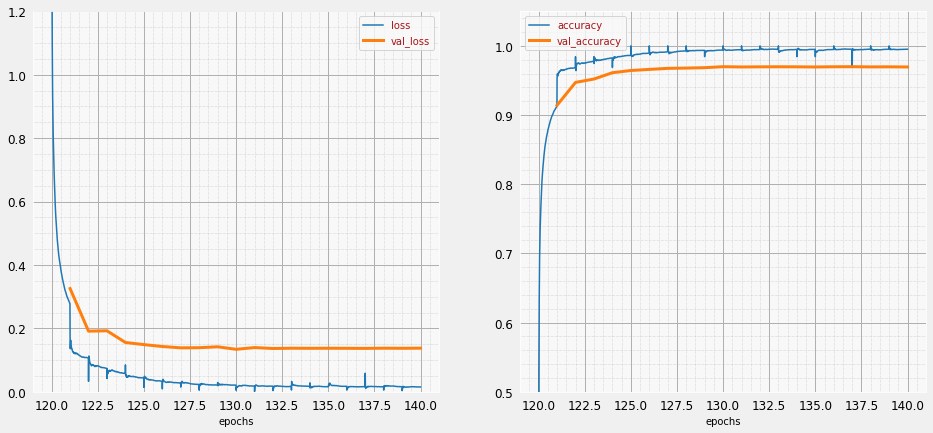

937/937 [==============================] - 5s 5ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.1376 - val_accuracy: 0.9695
Total training time : 93.408 sec


In [97]:
(history, model) = trainmodel(training_dataset, validation_dataset, [3,6,6], [12, 24, 32], 20, False)

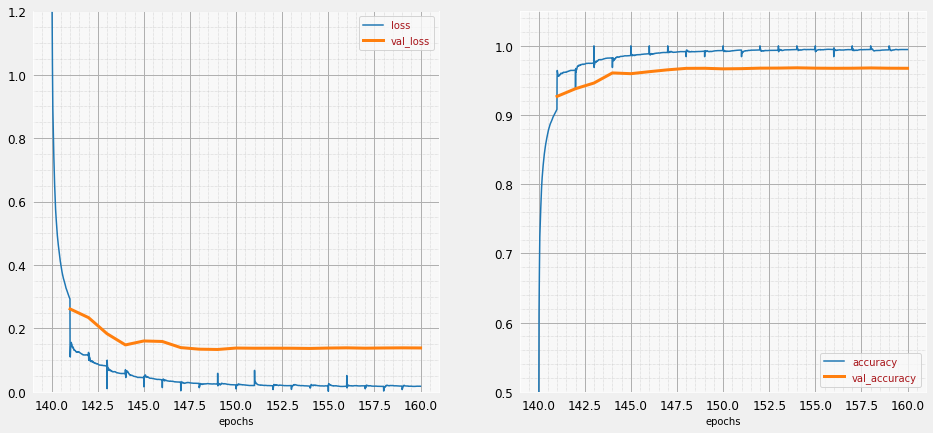

937/937 [==============================] - 4s 5ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.1383 - val_accuracy: 0.9676
Total training time : 90.551 sec


In [98]:
#data aug
(history, model) = trainmodel(training_dataset, validation_dataset, [3,6,6], [12, 24, 32], 20, True)

Le data augmentation étant une méthode de régularization, on attend une hausse des performances sur le validation set, mais les résultats sont à peu près similaires.

In [99]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_36 (Batc (None, 28, 28, 12)        36        
_________________________________________________________________
activation_36 (Activation)   (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_37 (Batc (None, 14, 14, 24)        72        
_________________________________________________________________
activation_37 (Activation)   (None, 14, 14, 24)      

Formule nombre de paramètres:
number_parameters = out_channels * (in_channels * kernel_h * kernel_w + 1)  # 1 for bias

Nombre de paramètres output conv2d_29 :

27648 = 32 * ( 24 * 6 * 6) #pas de bias

Il y a beaucoup de paramètres surtout au Dense layer.
Essayons de diminuer cela.

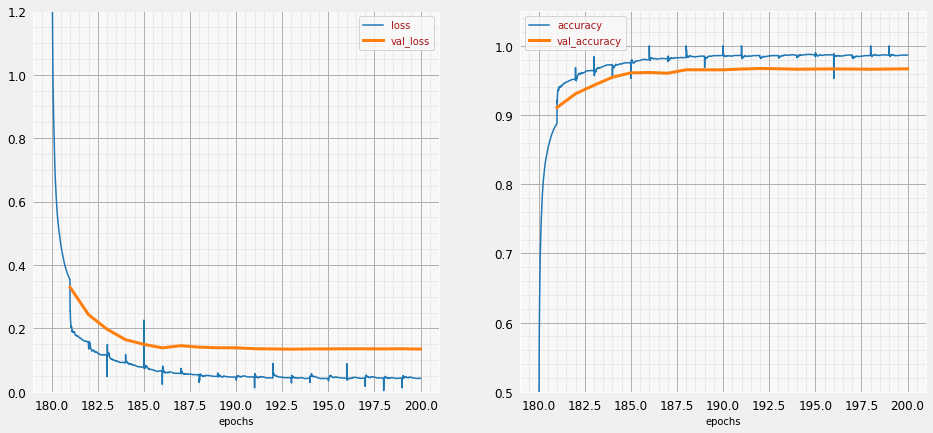

937/937 [==============================] - 5s 5ms/step - loss: 0.0424 - accuracy: 0.9868 - val_loss: 0.1347 - val_accuracy: 0.9668
Total training time : 90.247 sec


In [102]:
#avec différentes ajout de max pooling, apres le dernier conv semble être le meilleur emplacement
def trainmodel(td, vd, kernel, filter, ep, data_augmetation, padding='same'):
  augmentation = tf.keras.Sequential([
      tf.keras.layers.Reshape(input_shape=(28 * 28,), target_shape=(28, 28, 1))
    ])
  
  if data_augmentation:
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)))
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.01))  

  model = tf.keras.Sequential(
    [
        augmentation,
        
        tf.keras.layers.Conv2D(kernel_size=kernel[0], filters=filter[0], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[1], filters=filter[1], use_bias=False, 
                               padding= padding, strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Conv2D(kernel_size=kernel[2], filters=filter[2], use_bias=False, 
                               padding= padding, strides=2),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  starttime = time.time()

  history = model.fit(td, steps_per_epoch=steps_per_epoch, epochs= ep,
                    validation_data=vd, validation_steps=1, 
                    callbacks=[plot_training, lr_decay_callback])
  #callbacks=[plot_training, lr_decay_callback])

  print("Total training time : {0:.5g} sec".format(time.time() - starttime))
  return (history, model)
#data augmentation
(history, model) = trainmodel(training_dataset, validation_dataset, [3,6,6], [12, 24, 32], 20, True)

In [104]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_23 (Sequential)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_44 (Batc (None, 28, 28, 12)        36        
_________________________________________________________________
activation_44 (Activation)   (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_45 (Batc (None, 14, 14, 24)        72        
_________________________________________________________________
activation_45 (Activation)   (None, 14, 14, 24)      

On obtient les mêmes résultats avec 3 fois moins de paramètres. Cependant, après plusieurs changements d'hyperparamètres, les résultats restent identiques. Il faut ajouter d'autre layers!

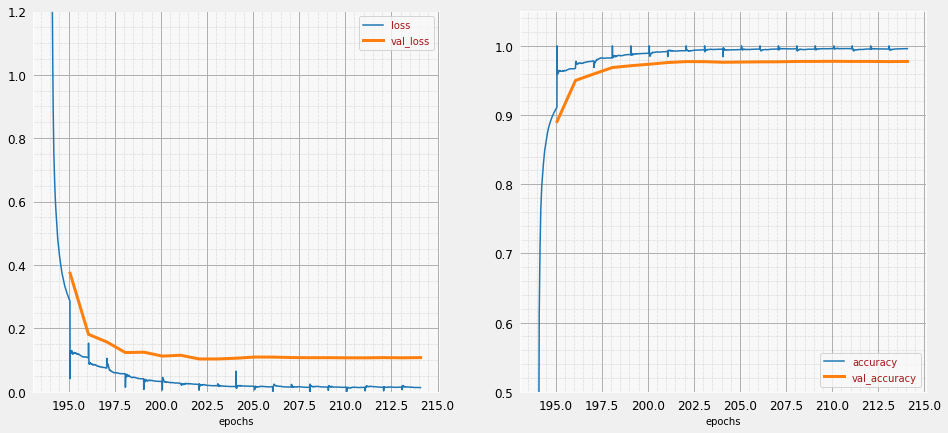

937/937 [==============================] - 6s 7ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.1079 - val_accuracy: 0.9775
Total training time : 122.49 sec


In [141]:
def trainmodel(td, vd, kernel, filter, ep, data_augmetation, padding='same'):
  augmentation = tf.keras.Sequential([
      tf.keras.layers.Reshape(input_shape=(28 * 28,), target_shape=(28, 28, 1))
    ])
  
  if data_augmentation:
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)))
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.01))  

  model = tf.keras.Sequential(
    [
        augmentation,
        
        tf.keras.layers.Conv2D(kernel_size=kernel[0], filters=filter[0], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[1], filters=filter[1], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        tf.keras.layers.Conv2D(kernel_size=kernel[2], filters=filter[2], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Conv2D(kernel_size=kernel[3], filters=filter[3], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
     
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  starttime = time.time()

  history = model.fit(td, steps_per_epoch=steps_per_epoch, epochs= ep,
                    validation_data=vd, validation_steps=1, 
                    callbacks=[plot_training, lr_decay_callback])
  #callbacks=[plot_training, lr_decay_callback])

  print("Total training time : {0:.5g} sec".format(time.time() - starttime))
  return (history, model)
#data augmentation
(history, model) = trainmodel(training_dataset, validation_dataset, [3, 3, 6, 6], [12, 24, 32, 64], 20, True)

Avec 1 MaxPooling et Conv2D en plus, il y a déjà une nette amélioration du loss et 1% en accuracy.


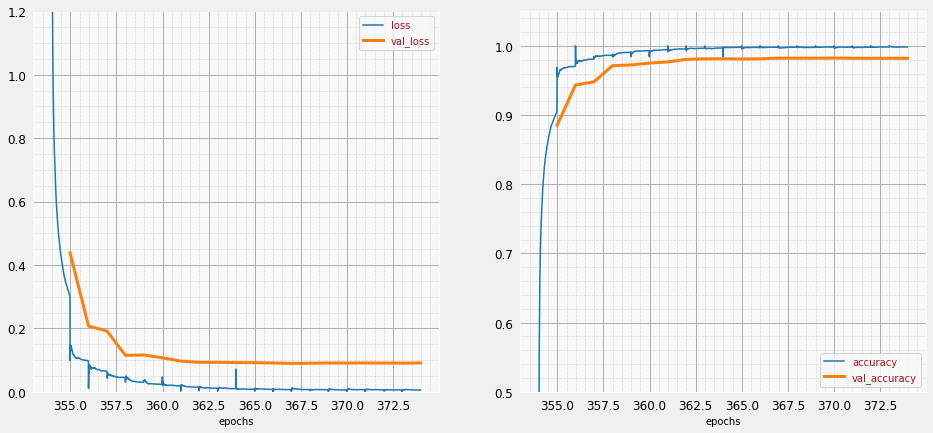

937/937 [==============================] - 6s 7ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0910 - val_accuracy: 0.9820
Total training time : 120.63 sec


In [166]:
def trainmodel(td, vd, kernel, filter, ep, data_augmetation, padding='same'):
  augmentation = tf.keras.Sequential([
      tf.keras.layers.Reshape(input_shape=(28 * 28,), target_shape=(28, 28, 1))
    ])
  
  if data_augmentation:
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)))
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.01))  

  model = tf.keras.Sequential(
    [
        augmentation,
        
        tf.keras.layers.Conv2D(kernel_size=kernel[0], filters=filter[0], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[1], filters=filter[1], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        tf.keras.layers.Conv2D(kernel_size=kernel[2], filters=filter[2], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[3], filters=filter[3], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Conv2D(kernel_size=kernel[4], filters=filter[4], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[5], filters=filter[5], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(150, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  starttime = time.time()

  history = model.fit(td, steps_per_epoch=steps_per_epoch, epochs= ep,
                    validation_data=vd, validation_steps=1, 
                    callbacks=[plot_training, lr_decay_callback])
  #callbacks=[plot_training, lr_decay_callback])

  print("Total training time : {0:.5g} sec".format(time.time() - starttime))
  return (history, model)
#data augmentation
(history, model) = trainmodel(training_dataset, validation_dataset, [3, 3, 3, 3, 6, 6], [12, 12, 32, 32, 64, 64], 20, True)

In [168]:
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print("Total params: {:,}\nTrainable params: {:,}\nNon-trainable params: {:,}".format(
    trainable_count + non_trainable_count, trainable_count, non_trainable_count))

Total params: 324,268
Trainable params: 323,536
Non-trainable params: 732


On a ajouté 2 Conv2D et encore 1 MaxPooling pour dépasser la barre des 98%.

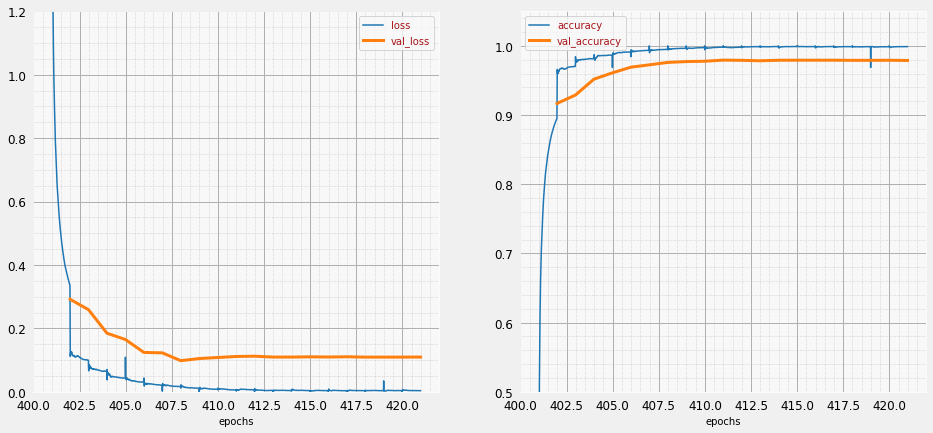

937/937 [==============================] - 7s 8ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.1096 - val_accuracy: 0.9789
Total training time : 147.08 sec


In [176]:
def trainmodel(td, vd, kernel, filter, ep, data_augmetation, padding='same'):
  augmentation = tf.keras.Sequential([
      tf.keras.layers.Reshape(input_shape=(28 * 28,), target_shape=(28, 28, 1))
    ])
  
  if data_augmentation:
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)))
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.01))  

  model = tf.keras.Sequential(
    [
        augmentation,
        
        tf.keras.layers.Conv2D(kernel_size=kernel[0], filters=filter[0], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[1], filters=filter[1], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        tf.keras.layers.Conv2D(kernel_size=kernel[2], filters=filter[2], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[3], filters=filter[3], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Conv2D(kernel_size=kernel[4], filters=filter[4], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[5], filters=filter[5], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[4], filters=filter[4], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.Conv2D(kernel_size=kernel[5], filters=filter[5], use_bias=False, 
                               padding= padding),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
     
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(150, use_bias=False),
        tf.keras.layers.BatchNormalization(center=True, scale=False),
        tf.keras.layers.Activation('relu'),
        
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  starttime = time.time()

  history = model.fit(td, steps_per_epoch=steps_per_epoch, epochs= ep,
                    validation_data=vd, validation_steps=1, 
                    callbacks=[plot_training, lr_decay_callback])
  #callbacks=[plot_training, lr_decay_callback])

  print("Total training time : {0:.5g} sec".format(time.time() - starttime))
  return (history, model)
#data augmentation
(history, model) = trainmodel(training_dataset, validation_dataset, [3, 3, 3, 3, 6, 6], [12, 12, 32, 32, 64, 64], 20, True)

In [177]:
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print("Total params: {:,}\nTrainable params: {:,}\nNon-trainable params: {:,}".format(
    trainable_count + non_trainable_count, trainable_count, non_trainable_count))

Total params: 542,764
Trainable params: 541,776
Non-trainable params: 988


On perd ici en efficacité, on commence à atteindre la limite pour le train d'un modele basique Conv+Batch+ReLu+Pooling. Cela peut-être dû au changement non efficace des poids pendant la back propagation.
En ajoutant de plus de layers avec des astuces comme de grands nombres de filters avec 1D convolution (bottleneck), Resnet etc...

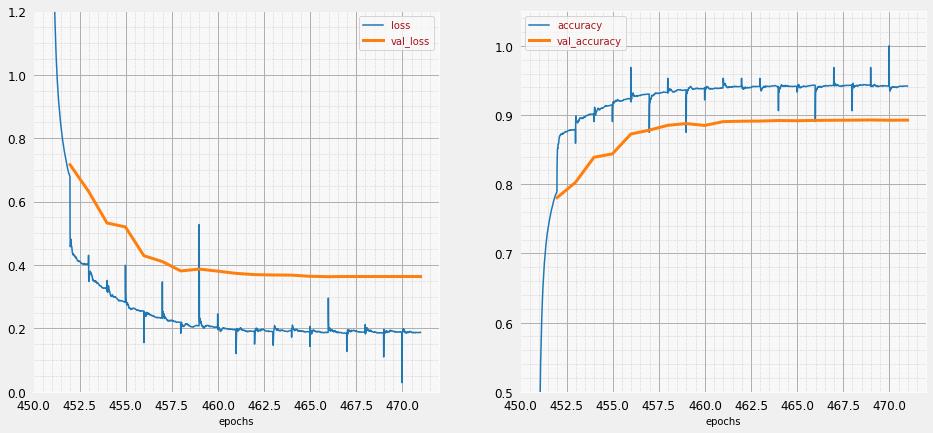

937/937 [==============================] - 5s 5ms/step - loss: 0.1873 - accuracy: 0.9419 - val_loss: 0.3635 - val_accuracy: 0.8927
Total training time : 92.261 sec


In [183]:
def trainmodel(td, vd, kernel, filter, ep, data_augmetation, padding='same'):
  augmentation = tf.keras.Sequential([
      tf.keras.layers.Reshape(input_shape=(28 * 28,), target_shape=(28, 28, 1))
    ])
  
  if data_augmentation:
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)))
    augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.01))  

  model = tf.keras.Sequential(
    [
        augmentation,
        
        tf.keras.layers.Conv2D(filter[0], kernel_size=kernel[0],activation='relu'),
        tf.keras.layers.Conv2D(filter[1], kernel[1], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.10),
        tf.keras.layers.Conv2D(filter[2], kernel[2], activation='relu'),
        tf.keras.layers.Conv2D(filter[3], kernel[3], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Dropout(0.10),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(10, activation='softmax'),                        
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  starttime = time.time()

  history = model.fit(td, steps_per_epoch=steps_per_epoch, epochs= ep,
                    validation_data=vd, validation_steps=1, 
                    callbacks=[plot_training, lr_decay_callback])
  #callbacks=[plot_training, lr_decay_callback])

  print("Total training time : {0:.5g} sec".format(time.time() - starttime))
  return (history, model)
#data augmentation
(history, model) = trainmodel(training_dataset, validation_dataset, [3,3,6,6], [12, 24, 32, 64], 20, True)

On peut voir l'effet lorsqu'il y a trop de regularization : l'apprentissage ralentie évidemment. Il faut donc plus d'epochs pour un apprentissage plus lent, mais peut-être plus efficace sur le validation set.